In [70]:
#INTERACCIÓN CON EL BUSCADOR
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select, WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time

# Configuración del navegador
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=options)
driver.get("https://servicios.infoleg.gob.ar/infolegInternet/mostrarBusquedaNormas.do")
time.sleep(2)

# Seleccionar tipo de norma y buscar
Select(driver.find_element(By.NAME, "tipoNorma")).select_by_visible_text("Ley")
driver.find_element(By.NAME, "texto").send_keys("Energía")
driver.find_element(By.CSS_SELECTOR, "input[value='Buscar']").click()

# Recolectar links de todas las páginas de resultados
normas_links = []

while True:
    # Esperar que aparezcan los resultados
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "a[href*='verNorma.do']"))
    )
    time.sleep(1.5)

    # Extraer los links de la página actual
    links = driver.find_elements(By.CSS_SELECTOR, "a[href*='verNorma.do']")
    for link in links:
        texto = link.text.strip()
        if "ver norma y textos resaltados" in texto.lower():
            continue
        href = link.get_attribute("href")
        normas_links.append((texto, href))

    print(f"✅ Página recolectada. Total acumulado: {len(normas_links)} normas")

    # Verificar si hay botón de "Siguiente"
    try:
        boton_siguiente = driver.find_element(By.CLASS_NAME, "page-right")
        if not boton_siguiente.is_enabled():
            print("⛔ No hay más páginas disponibles.")
            break
        else:
            boton_siguiente.click()
            time.sleep(2.5)
    except Exception:
        print("⛔ Botón 'Siguiente' no encontrado. Fin de paginación.")
        break

# Eliminar duplicados por URL
normas_links = list(dict.fromkeys(normas_links))


print(f"Se recolectaron {len(normas_links)} normas en la página de resultados")

# Lista de normas estructuradas
normas_data = []

# Iterar norma por norma
for texto_norma, href_norma in normas_links:
    print(f"\nAbriendo norma: {texto_norma}")
    driver.execute_script("window.open(arguments[0]);", href_norma)
    driver.switch_to.window(driver.window_handles[-1])
    time.sleep(3)

    norma_dict = {
        "titulo": texto_norma,
        "enlace": href_norma,
        "tiene_texto_completo_actualizado": False,
        "vinculos_modificacion": []
    }

    # Texto completo actualizado
    try:
        link_texto_actualizado = driver.find_elements(By.CSS_SELECTOR, "a[href*='texact.htm']")
        if link_texto_actualizado:
            norma_dict["tiene_texto_completo_actualizado"] = True
    except Exception as e:
        print(f"  No se pudo verificar texto completo actualizado: {e}")

    # Vínculos de modificación
    try:
        vinculos = driver.find_elements(By.CSS_SELECTOR, "a[href*='verVinculos.do']")
        for vinculo in vinculos:
            texto_vinculo = vinculo.text.strip().lower()
            href_vinculo = vinculo.get_attribute("href")
            if "modifica o complementa" in texto_vinculo or "es complementada o modificada por" in texto_vinculo:
                norma_dict["vinculos_modificacion"].append({
                    "tipo": texto_vinculo,
                    "enlace": href_vinculo,
                    "detalle": []
                })
    except Exception as e:
        print(f"  Error al recolectar vínculos: {e}")

    # Procesar vínculos
    for v in norma_dict["vinculos_modificacion"]:
        try:
            driver.execute_script("window.open(arguments[0]);", v["enlace"])
            driver.switch_to.window(driver.window_handles[-1])
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "table")))

            # Obtener contenido HTML para bs4
            html = driver.page_source
            soup = BeautifulSoup(html, "html.parser")
            tabla = soup.find("table")

            if tabla:
                filas = tabla.find_all("tr")[1:]  # Omitir encabezado
                for fila in filas:
                    columnas = fila.find_all("td")
                    if len(columnas) >= 3:
                        v["detalle"].append({
                            "norma": columnas[0].get_text(strip=True),
                            "fecha": columnas[1].get_text(strip=True),
                            "descripcion": columnas[2].get_text(strip=True)
                        })

            driver.close()
            driver.switch_to.window(driver.window_handles[-2])

        except Exception as e:
            print(f"    Error al procesar vínculo {v['tipo']}: {e}")

    normas_data.append(norma_dict)

    driver.close()
    driver.switch_to.window(driver.window_handles[0])

# Mostrar resultados estructurados
for norma in normas_data:
    print("\nTítulo:", norma["titulo"])
    print("Enlace:", norma["enlace"])
    print("¿Texto completo actualizado?:", "Sí" if norma["tiene_texto_completo_actualizado"] else "No")
    for v in norma["vinculos_modificacion"]:
        print("  -", v["tipo"])
        for d in v["detalle"]:
            print(f"     > {d['norma']} | {d['fecha']} | {d['descripcion']}git clone https://github.com/trtrilnik/politica-energetica-ar.git
cd politica-energetica-ar")

driver.quit()


✅ Página recolectada. Total acumulado: 50 normas
✅ Página recolectada. Total acumulado: 100 normas
✅ Página recolectada. Total acumulado: 150 normas
✅ Página recolectada. Total acumulado: 200 normas
✅ Página recolectada. Total acumulado: 250 normas
✅ Página recolectada. Total acumulado: 300 normas
✅ Página recolectada. Total acumulado: 350 normas
✅ Página recolectada. Total acumulado: 363 normas
⛔ Botón 'Siguiente' no encontrado. Fin de paginación.
Se recolectaron 363 normas en la página de resultados

Abriendo norma: Ley 27450

Abriendo norma: Ley 27424

Abriendo norma: Ley 27346

Abriendo norma: Ley 27191

Abriendo norma: Ley 26969

Abriendo norma: Ley 22961

Abriendo norma: Ley 26766

Abriendo norma: Ley 26771

Abriendo norma: Ley 26770

Abriendo norma: Ley 26765

Abriendo norma: Ley 26767

Abriendo norma: Ley 26768

Abriendo norma: Ley 26675

Abriendo norma: Ley 26659

Abriendo norma: Ley 26566

Abriendo norma: Ley 26565

Abriendo norma: Ley 26561

Abriendo norma: Ley 26556

Abrien

In [72]:
import json

# Guardar normas recolectadas en archivo JSON
with open("normas_mult_infoleg.json", "w", encoding="utf-8") as f:
    json.dump(normas_data, f, ensure_ascii=False, indent=4)

print("✅ Datos guardados en normas_mult_infoleg.json")


✅ Datos guardados en normas_mult_infoleg.json


In [74]:
#Scraping inicial del texto completo de cada norma listada en normas_infoleg.json

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import json
import time
import os

# Leer archivo JSON con normas
with open("normas_mult_infoleg.json", "r", encoding="utf-8") as f:
    normas_data = json.load(f)

# Inicializar navegador
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=options)

# Crear carpeta para depuración opcional
os.makedirs("html_backup", exist_ok=True)

# Lista para almacenar textos múltiples
textos_normas = []

def obtener_texto_y_tablas(url_texto, driver, etiqueta_backup):
    """Accede a una URL de texto (original o actualizado), devuelve texto plano y tablas como listas"""
    try:
        driver.get(url_texto)
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
        time.sleep(1.5)

        html = driver.page_source
        soup = BeautifulSoup(html, "html.parser")

        # Backup HTML
        with open(f"html_backup/{etiqueta_backup}.html", "w", encoding="utf-8") as f:
            f.write(html)

        # Texto plano acumulado
        texto = []
        for elem in soup.find("body").descendants:
            if elem.name in ["p", "div", "span", "body"] and elem.string:
                content = elem.get_text(strip=True)
                if content:
                    texto.append(content)
            elif isinstance(elem, str):
                stripped = elem.strip()
                if stripped:
                    texto.append(stripped)

        texto_plano = "\n".join(texto).strip()

        # Tablas procesadas
        tablas = []
        for tabla in soup.find_all("table"):
            filas = tabla.find_all("tr")
            if not filas:
                continue
            encabezados = [th.get_text(strip=True) for th in filas[0].find_all(["th", "td"])]
            for fila in filas[1:]:
                celdas = [td.get_text(strip=True) for td in fila.find_all(["td", "th"])]
                if len(celdas) == len(encabezados):
                    tablas.append(dict(zip(encabezados, celdas)))
                else:
                    tablas.append({"fila_completa": " | ".join(celdas)})

        return texto_plano, tablas

    except Exception as e:
        print(f"⚠️ Error al obtener contenido en {etiqueta_backup}: {e}")
        return "", []

# -------- SCRAPING --------
for idx, norma in enumerate(normas_data, start=1):
    print(f"\n📘 [{idx}/{len(normas_data)}] Accediendo a: {norma['titulo']}")
    url = norma["enlace"]
    driver.get(url)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
    time.sleep(1.5)

    texto_original, tablas_original = "", []
    texto_actualizado, tablas_actualizado = "", []

    # -------- TEXTO ORIGINAL --------
    try:
        link_original = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.PARTIAL_LINK_TEXT, "Texto completo de la norma"))
        )
        link_original_url = link_original.get_attribute("href")
        print("🧾 Encontrado enlace a texto original.")
        texto_original, tablas_original = obtener_texto_y_tablas(link_original_url, driver, f"{norma['titulo'].replace('/', '_')}_original")
    except Exception as e:
        print("⚠️ No se encontró enlace a texto original:", e)

    # -------- TEXTO ACTUALIZADO --------
    if norma.get("tiene_texto_completo_actualizado"):
        try:
            driver.get(url)
            WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
            link_actualizado = WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.PARTIAL_LINK_TEXT, "Texto actualizado de la norma"))
            )
            link_actualizado_url = link_actualizado.get_attribute("href")
            print("🔄 Encontrado enlace a texto actualizado.")
            texto_actualizado, tablas_actualizado = obtener_texto_y_tablas(link_actualizado_url, driver, f"{norma['titulo'].replace('/', '_')}_actualizado")
        except Exception as e:
            print("⚠️ No se encontró enlace a texto actualizado:", e)

    # Guardar ambos textos y tablas
    textos_normas.append({
        "titulo": norma["titulo"],
        "enlace": norma["enlace"],
        "texto_original": texto_original,
        "tablas_original": tablas_original,
        "texto_actualizado": texto_actualizado,
        "tablas_actualizado": tablas_actualizado
    })

# Guardar resultado final
with open("textos_normas_mult.json", "w", encoding="utf-8") as f:
    json.dump(textos_normas, f, ensure_ascii=False, indent=2)

driver.quit()
print("✅ Textos (original y actualizado) + tablas guardados en textos_normas_doble.json")



📘 [1/363] Accediendo a: Ley 27450
🧾 Encontrado enlace a texto original.

📘 [2/363] Accediendo a: Ley 27424
🧾 Encontrado enlace a texto original.
🔄 Encontrado enlace a texto actualizado.

📘 [3/363] Accediendo a: Ley 27346
🧾 Encontrado enlace a texto original.
🔄 Encontrado enlace a texto actualizado.

📘 [4/363] Accediendo a: Ley 27191
🧾 Encontrado enlace a texto original.
🔄 Encontrado enlace a texto actualizado.

📘 [5/363] Accediendo a: Ley 26969
🧾 Encontrado enlace a texto original.

📘 [6/363] Accediendo a: Ley 22961
🧾 Encontrado enlace a texto original.

📘 [7/363] Accediendo a: Ley 26766
🧾 Encontrado enlace a texto original.

📘 [8/363] Accediendo a: Ley 26771
🧾 Encontrado enlace a texto original.

📘 [9/363] Accediendo a: Ley 26770
🧾 Encontrado enlace a texto original.

📘 [10/363] Accediendo a: Ley 26765
🧾 Encontrado enlace a texto original.

📘 [11/363] Accediendo a: Ley 26767
🧾 Encontrado enlace a texto original.

📘 [12/363] Accediendo a: Ley 26768
🧾 Encontrado enlace a texto original

In [76]:
#PARSEO texto_normas_doble.json

import json
import re

# -------------------------
# Regex para parseo legal
# -------------------------
re_titulo = re.compile(r'^(T[IÍ]TULO\s+[IVXLCDM]+.*?)$', re.IGNORECASE)
re_capitulo = re.compile(r'^(CAP[IÍ]TULO\s+[IVXLCDM]+.*?)$', re.IGNORECASE)
re_articulo = re.compile(r'^(ART[ÍI]CULO\s+\d+[º°]?)\s*[—\-]?\s*(.*)', re.IGNORECASE)

# -------------------------
# Parser con soporte de inserción de tablas
# -------------------------
def parsear_texto_con_tablas(texto, tablas):
    estructura = []
    tit_actual = None
    cap_actual = None
    art_actual = None
    buffer = []

    lineas = texto.splitlines()

    def flush_articulo():
        nonlocal art_actual, buffer
        if art_actual:
            art_actual["texto"] += " " + " ".join(buffer).strip()
            if cap_actual:
                cap_actual["contenido"].append(art_actual)
            elif tit_actual:
                tit_actual["contenido"].append(art_actual)
            else:
                estructura.append(art_actual)
            art_actual = None
            buffer.clear()

    def flush_capitulo():
        nonlocal cap_actual
        if cap_actual:
            if tit_actual:
                tit_actual["contenido"].append(cap_actual)
            else:
                estructura.append(cap_actual)
            cap_actual = None

    def flush_titulo():
        nonlocal tit_actual
        if tit_actual:
            estructura.append(tit_actual)
            tit_actual = None

    for linea in lineas:
        linea = linea.strip()
        if not linea:
            continue

        if (m := re_titulo.match(linea)):
            flush_articulo()
            flush_capitulo()
            flush_titulo()
            tit_actual = {
                "tipo": "titulo",
                "texto": m.group(1).strip(),
                "contenido": []
            }

        elif (m := re_capitulo.match(linea)):
            flush_articulo()
            flush_capitulo()
            cap_actual = {
                "tipo": "capitulo",
                "texto": m.group(1).strip(),
                "contenido": []
            }

        elif (m := re_articulo.match(linea)):
            flush_articulo()
            art_actual = {
                "tipo": "articulo",
                "numero": m.group(1).strip(),
                "texto": m.group(2).strip()
            }

        else:
            buffer.append(linea)

    flush_articulo()
    flush_capitulo()
    flush_titulo()

    # Insertar tablas como anexo_tabla
    for tabla in tablas:
        tabla_nodo = {
            "tipo": "anexo_tabla",
            "contenido": tabla
        }
        if cap_actual and isinstance(cap_actual.get("contenido"), list):
            cap_actual["contenido"].append(tabla_nodo)
        elif tit_actual and isinstance(tit_actual.get("contenido"), list):
            tit_actual["contenido"].append(tabla_nodo)
        elif estructura and isinstance(estructura[-1], dict) and isinstance(estructura[-1].get("contenido"), list):
            estructura[-1]["contenido"].append(tabla_nodo)
        else:
            estructura.append(tabla_nodo)

    return estructura  

# -------------------------
# Procesar archivo de textos y tablas
# -------------------------
with open("textos_normas_mult.json", "r", encoding="utf-8") as f:
    normas = json.load(f)

estructuras_normas = []

for norma in normas:
    print(f"📘 Parseando: {norma['titulo']}")
    texto_ori = norma.get("texto_original", "")
    texto_act = norma.get("texto_actualizado", "")
    tablas_ori = norma.get("tablas_original", [])
    tablas_act = norma.get("tablas_actualizado", [])

    estructura_ori = parsear_texto_con_tablas(texto_ori, tablas_ori) if texto_ori else []
    estructura_act = parsear_texto_con_tablas(texto_act, tablas_act) if texto_act else []

    estructuras_normas.append({
        "titulo": norma["titulo"],
        "enlace": norma["enlace"],
        "estructura_original": estructura_ori,
        "estructura_actualizada": estructura_act
    })

# -------------------------
# Guardar estructura completa con anexos
# -------------------------
with open("estructuras_normas_363.json", "w", encoding="utf-8") as f:
    json.dump(estructuras_normas, f, ensure_ascii=False, indent=2)

print("✅ Archivo generado: estructuras_normas_363.json")


📘 Parseando: Ley 27450
📘 Parseando: Ley 27424
📘 Parseando: Ley 27346
📘 Parseando: Ley 27191
📘 Parseando: Ley 26969
📘 Parseando: Ley 22961
📘 Parseando: Ley 26766
📘 Parseando: Ley 26771
📘 Parseando: Ley 26770
📘 Parseando: Ley 26765
📘 Parseando: Ley 26767
📘 Parseando: Ley 26768
📘 Parseando: Ley 26675
📘 Parseando: Ley 26659
📘 Parseando: Ley 26566
📘 Parseando: Ley 26565
📘 Parseando: Ley 26561
📘 Parseando: Ley 26556
📘 Parseando: Ley 26422
📘 Parseando: Ley 26402
📘 Parseando: Ley 26396
📘 Parseando: Ley 26388
📘 Parseando: Ley 26381
📘 Parseando: Ley 26337
📘 Parseando: Ley 26350
📘 Parseando: Ley 26338
📘 Parseando: Ley 26198
📘 Parseando: Ley 26197
📘 Parseando: Ley 26190
📘 Parseando: Ley 26184
📘 Parseando: Ley 26158
📘 Parseando: Ley 26154
📘 Parseando: Ley 19459
📘 Parseando: Ley 19815
📘 Parseando: Ley 21774
📘 Parseando: Ley S 22033
📘 Parseando: Ley 26123
📘 Parseando: Ley 26095
📘 Parseando: Ley 26078
📘 Parseando: Ley 26074
📘 Parseando: Ley 26063
📘 Parseando: Ley 26058
📘 Parseando: Ley 26028
📘 Parsean

In [66]:
import json
import os

# Cargar estructura parseada
with open("estructuras_normas_con_tablas.json", "r", encoding="utf-8") as f:
    leyes = json.load(f)

# Crear carpeta de salida
os.makedirs("normas_markdown", exist_ok=True)

def markdown_tabla(tabla):
    """Convierte lista de dicts a tabla markdown"""
    if not isinstance(tabla, list) or not tabla:
        return "_(tabla vacía o formato inválido)_"
    if not isinstance(tabla[0], dict):
        return "_(formato inesperado en tabla)_"

    columnas = list(tabla[0].keys())
    encabezado = "| " + " | ".join(columnas) + " |"
    separador = "| " + " | ".join(["---"] * len(columnas)) + " |"
    filas = []
    for fila in tabla:
        valores = [str(fila.get(col, "")).replace("\n", " ") for col in columnas]
        filas.append("| " + " | ".join(valores) + " |")
    return "\n".join([encabezado, separador] + filas)


def procesar_estructura(estructura):
    md = ""
    for nodo in estructura:
        tipo = nodo.get("tipo", "")
        if tipo == "titulo":
            md += f"\n### {nodo['texto']}\n"
            md += procesar_estructura(nodo.get("contenido", []))
        elif tipo == "capitulo":
            md += f"\n#### {nodo['texto']}\n"
            md += procesar_estructura(nodo.get("contenido", []))
        elif tipo == "articulo":
            md += f"\n- **{nodo['numero']}**\n  {nodo['texto']}\n"
        elif tipo == "anexo_tabla":
            md += f"\n#### 📊 Anexo - Tabla\n"
            contenido = nodo.get("contenido", [])
            if isinstance(contenido, dict):
                # Convertir dict único a lista de un solo dict
                contenido = [contenido]
            md += markdown_tabla(contenido) + "\n"


        else:
            md += f"\n{text}\n"
    return md

for ley in leyes:
    titulo = ley["titulo"]
    enlace = ley["enlace"]
    estructura_ori = ley.get("estructura_original", [])
    estructura_act = ley.get("estructura_actualizada", [])

    filename = f"normas_markdown/{titulo.replace('/', '_').replace(' ', '_')}.md"
    with open(filename, "w", encoding="utf-8") as f:
        f.write(f"# {titulo}\n")
        f.write(f"🔗 Enlace: {enlace}\n")

        if estructura_ori:
            f.write("\n\n## 📜 Texto Original\n")
            f.write(procesar_estructura(estructura_ori))

        if estructura_act:
            f.write("\n\n## 🔄 Texto Actualizado\n")
            f.write(procesar_estructura(estructura_act))

print("✅ Archivos Markdown generados en la carpeta 'normas_markdown'")


✅ Archivos Markdown generados en la carpeta 'normas_markdown'


In [80]:
import json
import re

# Palabras clave para clasificación
CLAVES_ALTA = [
    "política energética", "plan energético", "infraestructura energética",
    "hidrocarburos", "energía eléctrica", "energía nuclear" "energías renovables", "gas natural",
    "secretaría de energía", "desarrollo energético", "matriz energética", "Energía Atómica"
]

CLAVES_MEDIA = [
    "tarifa", "subsidio", "empresa estatal", "distribución", "producción energética",
    "inversión", "biocombustible", "combustible líquido", "CAMMESA", "ENARSA", "YPF", "Comisión Nacional de Energía Atómica", "CNEA"
]

def texto_de_norma(estructura):
    """Concatena todo el texto de una norma estructurada"""
    textos = []

    def recorrer(nodo):
        if isinstance(nodo, list):
            for x in nodo:
                recorrer(x)
        elif isinstance(nodo, dict):
            for k, v in nodo.items():
                if isinstance(v, (list, dict)):
                    recorrer(v)
                elif isinstance(v, str):
                    textos.append(v)

    recorrer(estructura)
    return "\n".join(textos).lower()


def clasificar_norma(titulo, estructura):
    """Evalúa una norma y devuelve su nivel de relevancia temática"""
    texto = (titulo + "\n" + texto_de_norma(estructura)).lower()
    count_energia = texto.count("energía")

    if any(clave in texto for clave in CLAVES_ALTA):
        return "alta"
    elif any(clave in texto for clave in CLAVES_MEDIA) or count_energia >= 5:
        return "media"
    elif count_energia >= 1:
        return "baja"
    else:
        return "irrelevante"


# 🔍 Leer archivo de entrada
with open("estructuras_normas_363.json", "r", encoding="utf-8") as f:
    normas = json.load(f)

# 🏷 Clasificar todas
for norma in normas:
    estructura = norma.get("estructura_actualizada") or norma.get("estructura_original") or []
    titulo = norma.get("titulo", "")
    relevancia = clasificar_norma(titulo, estructura)
    norma["relevancia_temática"] = relevancia

# 💾 Guardar el nuevo archivo clasificado
with open("normas_clasificadas.json", "w", encoding="utf-8") as f:
    json.dump(normas, f, ensure_ascii=False, indent=2)

print("✅ Archivo generado: normas_clasificadas.json")


✅ Archivo generado: normas_clasificadas.json


In [82]:
import json
import csv
import os

# Cargar archivo clasificado
with open("normas_clasificadas.json", "r", encoding="utf-8") as f:
    normas = json.load(f)

# Crear carpeta de salida
os.makedirs("csv_output", exist_ok=True)

# -------------------------
# 1️⃣ Extraer resumen principal
# -------------------------
def extraer_primer_articulo(estructura):
    if not estructura:
        return ""
    for bloque in estructura:
        if isinstance(bloque, dict) and bloque.get("tipo") == "articulo":
            return bloque.get("texto", "")
        elif "contenido" in bloque:
            res = extraer_primer_articulo(bloque["contenido"])
            if res:
                return res
    return ""

# -------------------------
# 2️⃣ Crear CSV plano por norma
# -------------------------
with open("csv_output/normas_filtradas.csv", "w", newline='', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["titulo", "enlace", "relevancia_temática", "primer_articulo"])

    for norma in normas:
        estructura = norma.get("estructura_actualizada") or norma.get("estructura_original")
        primer_art = extraer_primer_articulo(estructura)
        writer.writerow([
            norma.get("titulo", ""),
            norma.get("enlace", ""),
            norma.get("relevancia_temática", ""),
            primer_art
        ])

print("✅ CSV de normas generado en csv_output/normas_filtradas.csv")

# -------------------------
# 3️⃣ Generar resumen por nivel de relevancia
# -------------------------
from collections import Counter

conteo = Counter(norma.get("relevancia_temática", "sin_etiqueta") for norma in normas)

with open("csv_output/relevancia_resumen.csv", "w", newline='', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["relevancia", "cantidad"])
    for k, v in conteo.items():
        writer.writerow([k, v])

print("📊 Resumen generado en csv_output/relevancia_resumen.csv")


✅ CSV de normas generado en csv_output/normas_filtradas.csv
📊 Resumen generado en csv_output/relevancia_resumen.csv


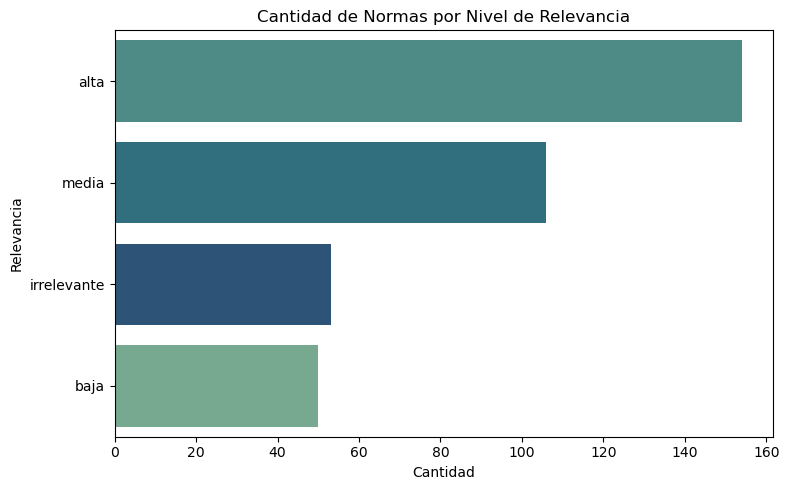

ValueError: attempt to get argmin of an empty sequence

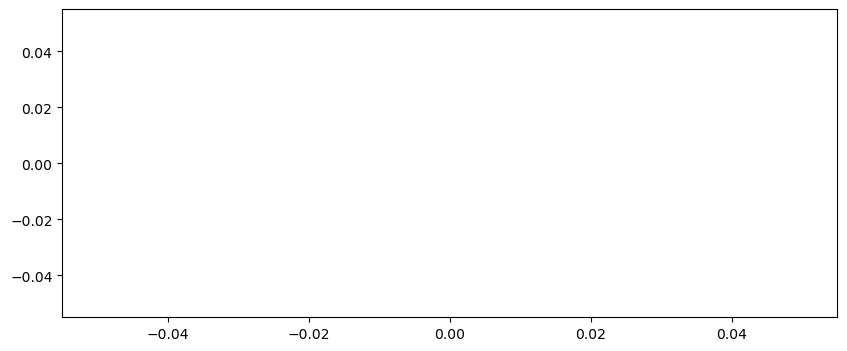

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# Cargar CSV de normas
df = pd.read_csv("csv_output/normas_filtradas.csv")

# -------------------------------
# 📊 1. Normas por relevancia
# -------------------------------
plt.figure(figsize=(8, 5))
sns.countplot(data=df, y="relevancia_temática", hue="relevancia_temática",
              order=df["relevancia_temática"].value_counts().index, palette="crest", legend=False)
plt.title("Cantidad de Normas por Nivel de Relevancia")
plt.xlabel("Cantidad")
plt.ylabel("Relevancia")
plt.tight_layout()
plt.show()

# -------------------------------
# ⏳ 2. Inferir año desde el título
# -------------------------------
def extraer_anio(titulo):
    m = re.search(r'\b(19|20)\d{2}\b', titulo)
    return int(m.group()) if m else None

df["anio"] = df["titulo"].apply(extraer_anio)
df_filtrado = df.dropna(subset=["anio"])

# Gráfico temporal
plt.figure(figsize=(10, 4))
sns.histplot(data=df_filtrado, x="anio", bins=range(int(df_filtrado["anio"].min()), int(df_filtrado["anio"].max()) + 1), color="skyblue")
plt.title("Distribución de Normas por Año")
plt.xlabel("Año")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()

# -------------------------------
# ☁️ 3. Nube de palabras del primer artículo
# -------------------------------
texto_completo = " ".join(df["primer_articulo"].dropna().tolist())

wordcloud = WordCloud(
    width=900, height=400,
    background_color='white',
    colormap='viridis',
    max_words=150,
    stopwords={"de", "la", "el", "que", "y", "a", "del", "por", "en", "los", "con", "al", "las", "se", "para"}
).generate(texto_completo)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("☁️ Nube de Palabras - Primeros Artículos", fontsize=14)
plt.show()


In [ ]:
Varoufakis$987024$%